In [1]:
# Cell 1: imports & helpers
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict

# For reproducibility during experiments
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [2]:
# Cell 2: worm simulation function

def generate_network(num_hosts, p_connect=0.02):
    """
    Generate an Erdős–Rényi adjacency list for num_hosts with connection probability p_connect.
    Returns adjacency list: dict node -> list(neighbors)
    """
    adj = {i: [] for i in range(num_hosts)}
    for i in range(num_hosts):
        for j in range(i + 1, num_hosts):
            if random.random() < p_connect:
                adj[i].append(j)
                adj[j].append(i)
    return adj

def simulate_worm(
    adj,
    initial_infected = [0],
    timesteps = 50,
    scans_per_infected = 5,
    scan_mode = "random",     # "random" or "local"
    prob_success = 0.3,      # probability that an attempted infection succeeds if target vulnerable
    patch_fraction = 0.0,    # fraction of hosts patched (immune) at start [0..1]
    rate_limit = None        # if int N, infected host can only attempt N scans per timestep (overrides scans_per_infected)
):
    
    nodes = list(adj.keys())
    N = len(nodes)
    
    # State: 0 = susceptible, 1 = infected, 2 = patched/immune
    state = {n: 0 for n in nodes}
    
    # Patch (make some hosts immune)
    num_patched = int(patch_fraction * N)
    patched = set(random.sample(nodes, num_patched)) if num_patched > 0 else set()
    for p in patched:
        state[p] = 2
    
    # Infect initial nodes (unless they were patched)
    infected_set = set()
    for i in initial_infected:
        if state[i] == 0:
            state[i] = 1
            infected_set.add(i)
    
    time_series = []
    history = []  # list of snapshots (copy of state)
    
    for t in range(timesteps):
        new_infected = set()
        # If no infected hosts remain, simulation halts early
        if not infected_set:
            time_series.extend([0] * (timesteps - t))
            break
        
        # Each infected host attempts scans
        for inf in list(infected_set):
            attempts = scans_per_infected if rate_limit is None else rate_limit
            for _ in range(attempts):
                if scan_mode == "random":
                    # pick uniformly among all nodes
                    target = random.choice(nodes)
                elif scan_mode == "local":
                    # prefer neighbors: 70% neighbor, 30% random global
                    nbrs = adj.get(inf, [])
                    if nbrs and random.random() < 0.7:
                        target = random.choice(nbrs)
                    else:
                        target = random.choice(nodes)
                else:
                    raise ValueError("Unknown scan_mode")
                
                # If target is susceptible, attempt infection
                if state[target] == 0:
                    if random.random() < prob_success:
                        new_infected.add(target)
                # else if target already infected or patched, nothing happens
        
        # Update states: newly infected become infected
        for ni in new_infected:
            state[ni] = 1
        infected_set.update(new_infected)
        
        # Record snapshot
        infected_count = sum(1 for v in state.values() if v == 1)
        time_series.append(infected_count)
        history.append(state.copy())
    # final snapshot appended if loop finishes normally might be shorter/longer
    details = {
        "final_state": state,
        "history": history,
        "patched_count": len(patched),
        "total_hosts": N
    }
    return time_series, details


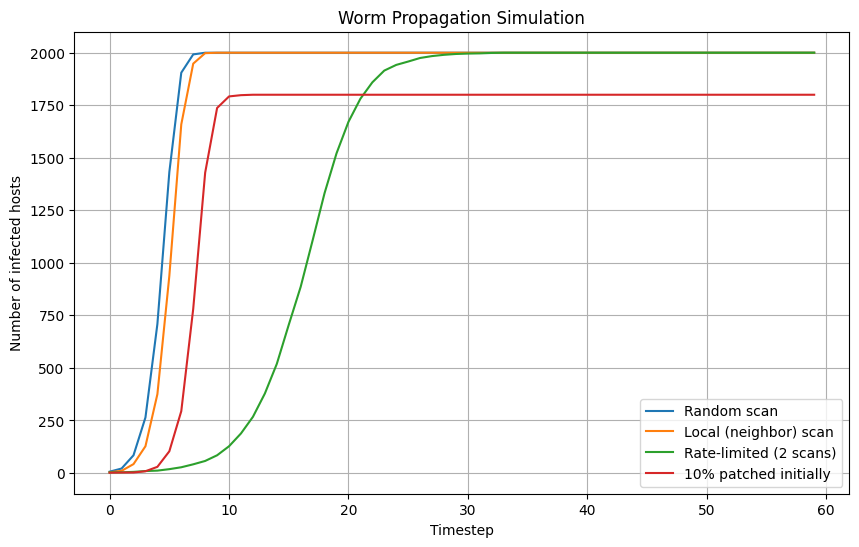

Final infected counts:
 Random scan: 2000
 Local scan:  2000
 Rate-limited: 2000
 10% patched: 1800


In [3]:
# Cell 3: run experiments (random vs local scanning) and visualize

def run_and_plot_experiments():
    num_hosts = 2000
    p_connect = 0.01  # sparse random graph
    adj = generate_network(num_hosts, p_connect=p_connect)
    
    # Baseline paramaters
    timesteps = 60
    scans_per_infected = 10
    prob_success = 0.25
    initial_infected = [random.randrange(num_hosts)]
    
    # Experiment A: Random scanning
    ts_random, details_random = simulate_worm(
        adj,
        initial_infected=initial_infected,
        timesteps=timesteps,
        scans_per_infected=scans_per_infected,
        scan_mode="random",
        prob_success=prob_success,
        patch_fraction=0.0,
        rate_limit=None
    )
    
    # Experiment B: Local (neighbor-biased) scanning
    ts_local, details_local = simulate_worm(
        adj,
        initial_infected=initial_infected,
        timesteps=timesteps,
        scans_per_infected=scans_per_infected,
        scan_mode="local",
        prob_success=prob_success,
        patch_fraction=0.0,
        rate_limit=None
    )
    
    # Experiment C: Containment via rate-limiting (limit scans to 2 per infected)
    ts_rate_limited, _ = simulate_worm(
        adj,
        initial_infected=initial_infected,
        timesteps=timesteps,
        scans_per_infected=scans_per_infected,
        scan_mode="random",
        prob_success=prob_success,
        patch_fraction=0.0,
        rate_limit=2
    )
    
    # Experiment D: Patching 10% of hosts at start
    ts_patched, _ = simulate_worm(
        adj,
        initial_infected=initial_infected,
        timesteps=timesteps,
        scans_per_infected=scans_per_infected,
        scan_mode="random",
        prob_success=prob_success,
        patch_fraction=0.10,
        rate_limit=None
    )
    
    # Plot results
    plt.figure(figsize=(10,6))
    plt.plot(range(len(ts_random)), ts_random, label="Random scan")
    plt.plot(range(len(ts_local)), ts_local, label="Local (neighbor) scan")
    plt.plot(range(len(ts_rate_limited)), ts_rate_limited, label="Rate-limited (2 scans)")
    plt.plot(range(len(ts_patched)), ts_patched, label="10% patched initially")
    plt.xlabel("Timestep")
    plt.ylabel("Number of infected hosts")
    plt.title("Worm Propagation Simulation")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print quick numeric summaries
    print("Final infected counts:")
    print(" Random scan:", ts_random[-1] if ts_random else 0)
    print(" Local scan: ", ts_local[-1] if ts_local else 0)
    print(" Rate-limited:", ts_rate_limited[-1] if ts_rate_limited else 0)
    print(" 10% patched:", ts_patched[-1] if ts_patched else 0)

# Run the experiments and plot
run_and_plot_experiments()
